# Распознавание таблеток на фото

In [1]:
from pathlib import Path
import torch

from dataset_executor import download_kaggle_cv_dataset, load_cv_data, debug_dataloader_output
from cv_model import PillClassifierDenseNet, train_model, evaluate_model_on_test_set

/media/all-c/U/Dophamine/Python/CV_classification_pill/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### В данном проекте все делается автоматически, но тестировалось на Linux (Kubuntu), дайте знать, если что-то не функционирует или работает неправильно

### Данный ноутбук (jupyter notebook) представляет из себя пайплайн, который загружает датасет, превращает его в DataLoader, затем обучает на нем модель классификации и показывает результаты ее работы на валидационной выборке. В конце следуют выводы и заметки, которые я сделал на основании работы 

## Этап 1. Подготовка данных

In [2]:
dataset_path = download_kaggle_cv_dataset("richardradli/ogyeiv2")
print(f"Датасет находится в: {dataset_path}")

2026-01-08 15:14:56 - dataset_executor - INFO - Папка '/media/all-c/U/Dophamine/Python/CV_classification_pill/dataset/ogyeiv2' не существует. Выполняется загрузка датасета.
2026-01-08 15:14:56 - dataset_executor - INFO - Начинается загрузка датасета 'richardradli/ogyeiv2' из Kaggle...
2026-01-08 15:14:57 - dataset_executor - INFO - Датасет загружен в кеш: /home/all-c/.cache/kagglehub/datasets/richardradli/ogyeiv2/versions/3
2026-01-08 15:14:57 - dataset_executor - INFO - Копирование датасета из кеша в '/media/all-c/U/Dophamine/Python/CV_classification_pill/dataset/ogyeiv2'...
2026-01-08 15:15:06 - dataset_executor - INFO - Датасет успешно скопирован в '/media/all-c/U/Dophamine/Python/CV_classification_pill/dataset/ogyeiv2'


Датасет находится в: /media/all-c/U/Dophamine/Python/CV_classification_pill/dataset/ogyeiv2


In [3]:


# Загружаем DataLoader'ы (batch_size=32 для 16GB VRAM с запасом)
train_loader, val_loader, test_loader, class_names_list = load_cv_data(
    dataset_path, 
    batch_size=32,
    image_size=100
)

print("ИНФОРМАЦИЯ О DATALOADER'АХ\n")

# Информация о каждом загрузчике
print(f"Train DataLoader:")
print(f"   Количество батчей: {len(train_loader)}")
print(f"   Всего изображений: {len(train_loader.dataset)}")

print(f"Validation DataLoader:")
print(f"   Количество батчей: {len(val_loader)}")
print(f"   Всего изображений: {len(val_loader.dataset)}")

print(f"Test DataLoader:")
print(f"   Количество батчей: {len(test_loader)}")
print(f"   Всего изображений: {len(test_loader.dataset)}")

# Выводим первый батч из каждого загрузчика
print("\nПервый батч из Train DataLoader:\n")


batch = next(iter(train_loader))
print(f"   Images shape: {batch['image'].shape}")  # [batch_size, 3, 224, 224]
print(f"   Labels shape: {batch['label'].shape}")  # [batch_size]
print(f"   BBox shape: {batch['bbox'].shape}")     # [batch_size, 4]

# Список всех классов с количеством изображений
print("\nСТАТИСТИКА ПО КЛАССАМ\n")
print(f"Всего уникальных классов в train : {len(class_names_list[0])}; в val: {len(class_names_list[1])}; в test: {len(class_names_list[2])}")


ИНФОРМАЦИЯ О DATALOADER'АХ

Train DataLoader:
   Количество батчей: 98
   Всего изображений: 3136
Validation DataLoader:
   Количество батчей: 21
   Всего изображений: 672
Test DataLoader:
   Количество батчей: 21
   Всего изображений: 672

Первый батч из Train DataLoader:

   Images shape: torch.Size([32, 3, 100, 100])
   Labels shape: torch.Size([32])
   BBox shape: torch.Size([32, 4])

СТАТИСТИКА ПО КЛАССАМ

Всего уникальных классов в train : 224; в val: 222; в test: 222


#### При беглом просмотре датасета на обучение, я заметил, что там почти везде от 10 до 20 изображений. Судя по выводу, все загрузилось корректно

#### Имеются два класса, которые есть только в train датасете:

In [4]:
class_difference = set(class_names_list[0]) - (set(class_names_list[1]) or set(class_names_list[2]))
print(f"Классы, которые не встречаются в val или test: {class_difference}")

Классы, которые не встречаются в val или test: {'indastad_1_5_mg_u', 'algoflex_forte_dolo_400_mg_s'}


### Дополнительно проверим, что DataLoader корректно создались:

In [5]:
# Проверяем что возвращает DataLoader
train_batch_data = debug_dataloader_output(train_loader, "Train DataLoader")


Отладка Train DataLoader
Тип возвращаемых данных: <class 'dict'>
Батч - это словарь с ключами: dict_keys(['image', 'label', 'bbox', 'class_name'])
  'image': Tensor, shape=torch.Size([32, 3, 100, 100]), dtype=torch.float32
  'label': Tensor, shape=torch.Size([32]), dtype=torch.int64
  'bbox': Tensor, shape=torch.Size([32, 4]), dtype=torch.float32
  'class_name': <class 'list'>


### Все корректно, батч должен иметь вид:

```Python
  'image': Tensor, shape=torch.Size([32, 3, 224, 224]), dtype=torch.float32
  'label': Tensor, shape=torch.Size([32]), dtype=torch.int64
  'bbox': Tensor, shape=torch.Size([32, 4]), dtype=torch.float32
  'class_name': <class 'list'>
```

## Этап 2. Теперь инициализируем модель на видеокарте, если она доступна в системе:

In [6]:
# Выбор  устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}, {device.type}")

# Создание модели
model = PillClassifierDenseNet(
    number_of_classes=224,
    dropout_rate=0.5,
    pretrained=True,
    freeze_backbone_initially=True
)

Используемое устройство: cuda, cuda


/media/all-c/U/Dophamine/Python/CV_classification_pill/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/all-c/U/Dophamine/Python/CV_classification_pill/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Этап 3. Переходим к обучению. Тут затерты стандартные ipywidget/python прогресс-бары, и просто выводятся раз в N секунд (у меня 30-35) результаты эпохи

In [7]:

# Обучение
training_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    max_epochs=20,
    train_accuracy_threshold=0.75,
    val_accuracy_threshold=0.50,
    min_train_accuracy_for_save=0.50,
    initial_learning_rate=1e-3,
    weight_decay=1e-4,
    label_smoothing=0.1,
    checkpoint_directory=Path('./checkpoints')
)


2026-01-08 15:15:24 - cv_model - INFO - Начало обучения на устройстве: cuda
2026-01-08 15:15:24 - cv_model - INFO - Количество параметров модели: 7,596,640
2026-01-08 15:15:24 - cv_model - INFO - Обучаемых параметров: 642,784
2026-01-08 15:15:24 - cv_model - INFO - ----------------------------------------------------------------------------------------------------


Эпоха [  1/20] | Время:  34.65s | LR: 9.76e-04
  Train: Loss=6.4693, Accuracy=  4.11%
  Val:   Loss=6.3135, Accuracy=  2.23%
----------------------------------------------------------------------------------------------------
Эпоха [  2/20] | Время:  33.59s | LR: 9.05e-04
  Train: Loss=3.8863, Accuracy= 26.31%
  Val:   Loss=7.1833, Accuracy=  3.57%
----------------------------------------------------------------------------------------------------
Эпоха [  3/20] | Время:  34.47s | LR: 7.94e-04
  Train: Loss=2.9149, Accuracy= 45.12%
  Val:   Loss=7.6942, Accuracy=  3.72%
----------------------------------------------------------------------------------------------------


2026-01-08 15:17:41 - cv_model - INFO -   ✓ Сохранена лучшая модель: best_model_epoch004_valacc3.57.pth


Эпоха [  4/20] | Время:  34.92s | LR: 6.55e-04
  Train: Loss=2.4230, Accuracy= 58.00%
  Val:   Loss=7.9608, Accuracy=  3.57%
----------------------------------------------------------------------------------------------------
Эпоха [  5/20] | Время:  35.74s | LR: 5.01e-04
  Train: Loss=2.1224, Accuracy= 66.10%
  Val:   Loss=8.0635, Accuracy=  3.42%
----------------------------------------------------------------------------------------------------
Эпоха [  6/20] | Время:  34.72s | LR: 3.46e-04
  Train: Loss=1.9707, Accuracy= 72.10%
  Val:   Loss=8.1991, Accuracy=  3.27%
----------------------------------------------------------------------------------------------------
Эпоха [  7/20] | Время:  33.91s | LR: 2.07e-04
  Train: Loss=1.8677, Accuracy= 76.34%
  Val:   Loss=8.2717, Accuracy=  3.57%
----------------------------------------------------------------------------------------------------

Достигнут порог точности на обучающей выборке: 76.34% >= 75.00%
Остановка обучения.

ОБУЧЕНИЕ З

## Этап 4. Проверим результаты

In [8]:

# Оценка на тестовой выборке
test_results = evaluate_model_on_test_set(
    model=model,
    test_loader=test_loader,
    device=device,
    checkpoint_path=Path(training_history['best_model_path']),
    class_names=class_names_list[0]
)

2026-01-08 15:19:26 - cv_model - INFO - Загружены веса из checkpoints/best_model_epoch004_valacc3.57.pth
2026-01-08 15:19:26 - cv_model - INFO -   Эпоха чекпоинта: 4
2026-01-08 15:19:26 - cv_model - INFO -   Val accuracy чекпоинта: 3.57%
2026-01-08 15:19:26 - cv_model - INFO - 
Оценка на тестовой выборке...



РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
Общая Accuracy: 24.11%
Правильно классифицировано: 162/672
Всего классов: 222

ТОП-5 ЛУЧШИХ КЛАССОВ (по F1-score)
Класс                          Precision    Recall       F1-Score     Samples   
--------------------------------------------------------------------------------
0 (acc_long_600_mg_s)              100.00%      100.00%      100.00%           3
2 (advil_ultra_forte_s)            100.00%      100.00%      100.00%           2
3 (advil_ultra_forte_u)            100.00%      100.00%      100.00%           4
4 (akineton_2_mg_s)                100.00%      100.00%      100.00%           2
6 (algoflex_forte_dolo_400_mg_s)     100.00%      100.00%      100.00%           3

ТОП-5 ХУДШИХ КЛАССОВ (по F1-score)
Класс                          Precision    Recall       F1-Score     Samples   
--------------------------------------------------------------------------------
20 (atorvastatin_teva_20_mg_s)       0.00%        0.00%        0.00%           2
21 (at

## Выводы

### Общий свод по результатам

Итоговая точность на тестовой выборке - 25% (в зависимости от отдельного обучения даже одним и тем же кодом, она плавала от 24% до 28%).

А точность на валидации - всего 3.42%, и не меняется. Почему? У меня есть две причины:
1. Малый датасет. Всего по 13 изображений на класс в среднем - это мало. Очень мало. А по 3 в валидации и в тесте вносят еще и значительную дисперсию, зависящую от конкретных условий съемки таблеток. В тесте они были лучше, чем в валидации
2. Модель - с нуля. Возможно, если зафайнтюнить уже готовый классификатор, то результаты будут выше. Хотя, вполне вероятно, что нет - ведь датасет все такой же малый, и модель может начать галлюцинировать.

Почему такой разброс по классам? Во-первых, как видно, на каждый класс по 2-4 изображения. Это вносит очень сильный эффект разброса на таком малом обучающем датасете, который не смог предоставить модели самые разные варианты представления таблеток. В предпоследнем прогоне было видно, что acc_long_600_mg и algoflex_forte_dolo_400_mg верно предсказались с обеих сторон. В случае неверно предсказанных такой только dulodet_60_mg - обе стороны по нулям. Давайте посмотрим на пилюлю.

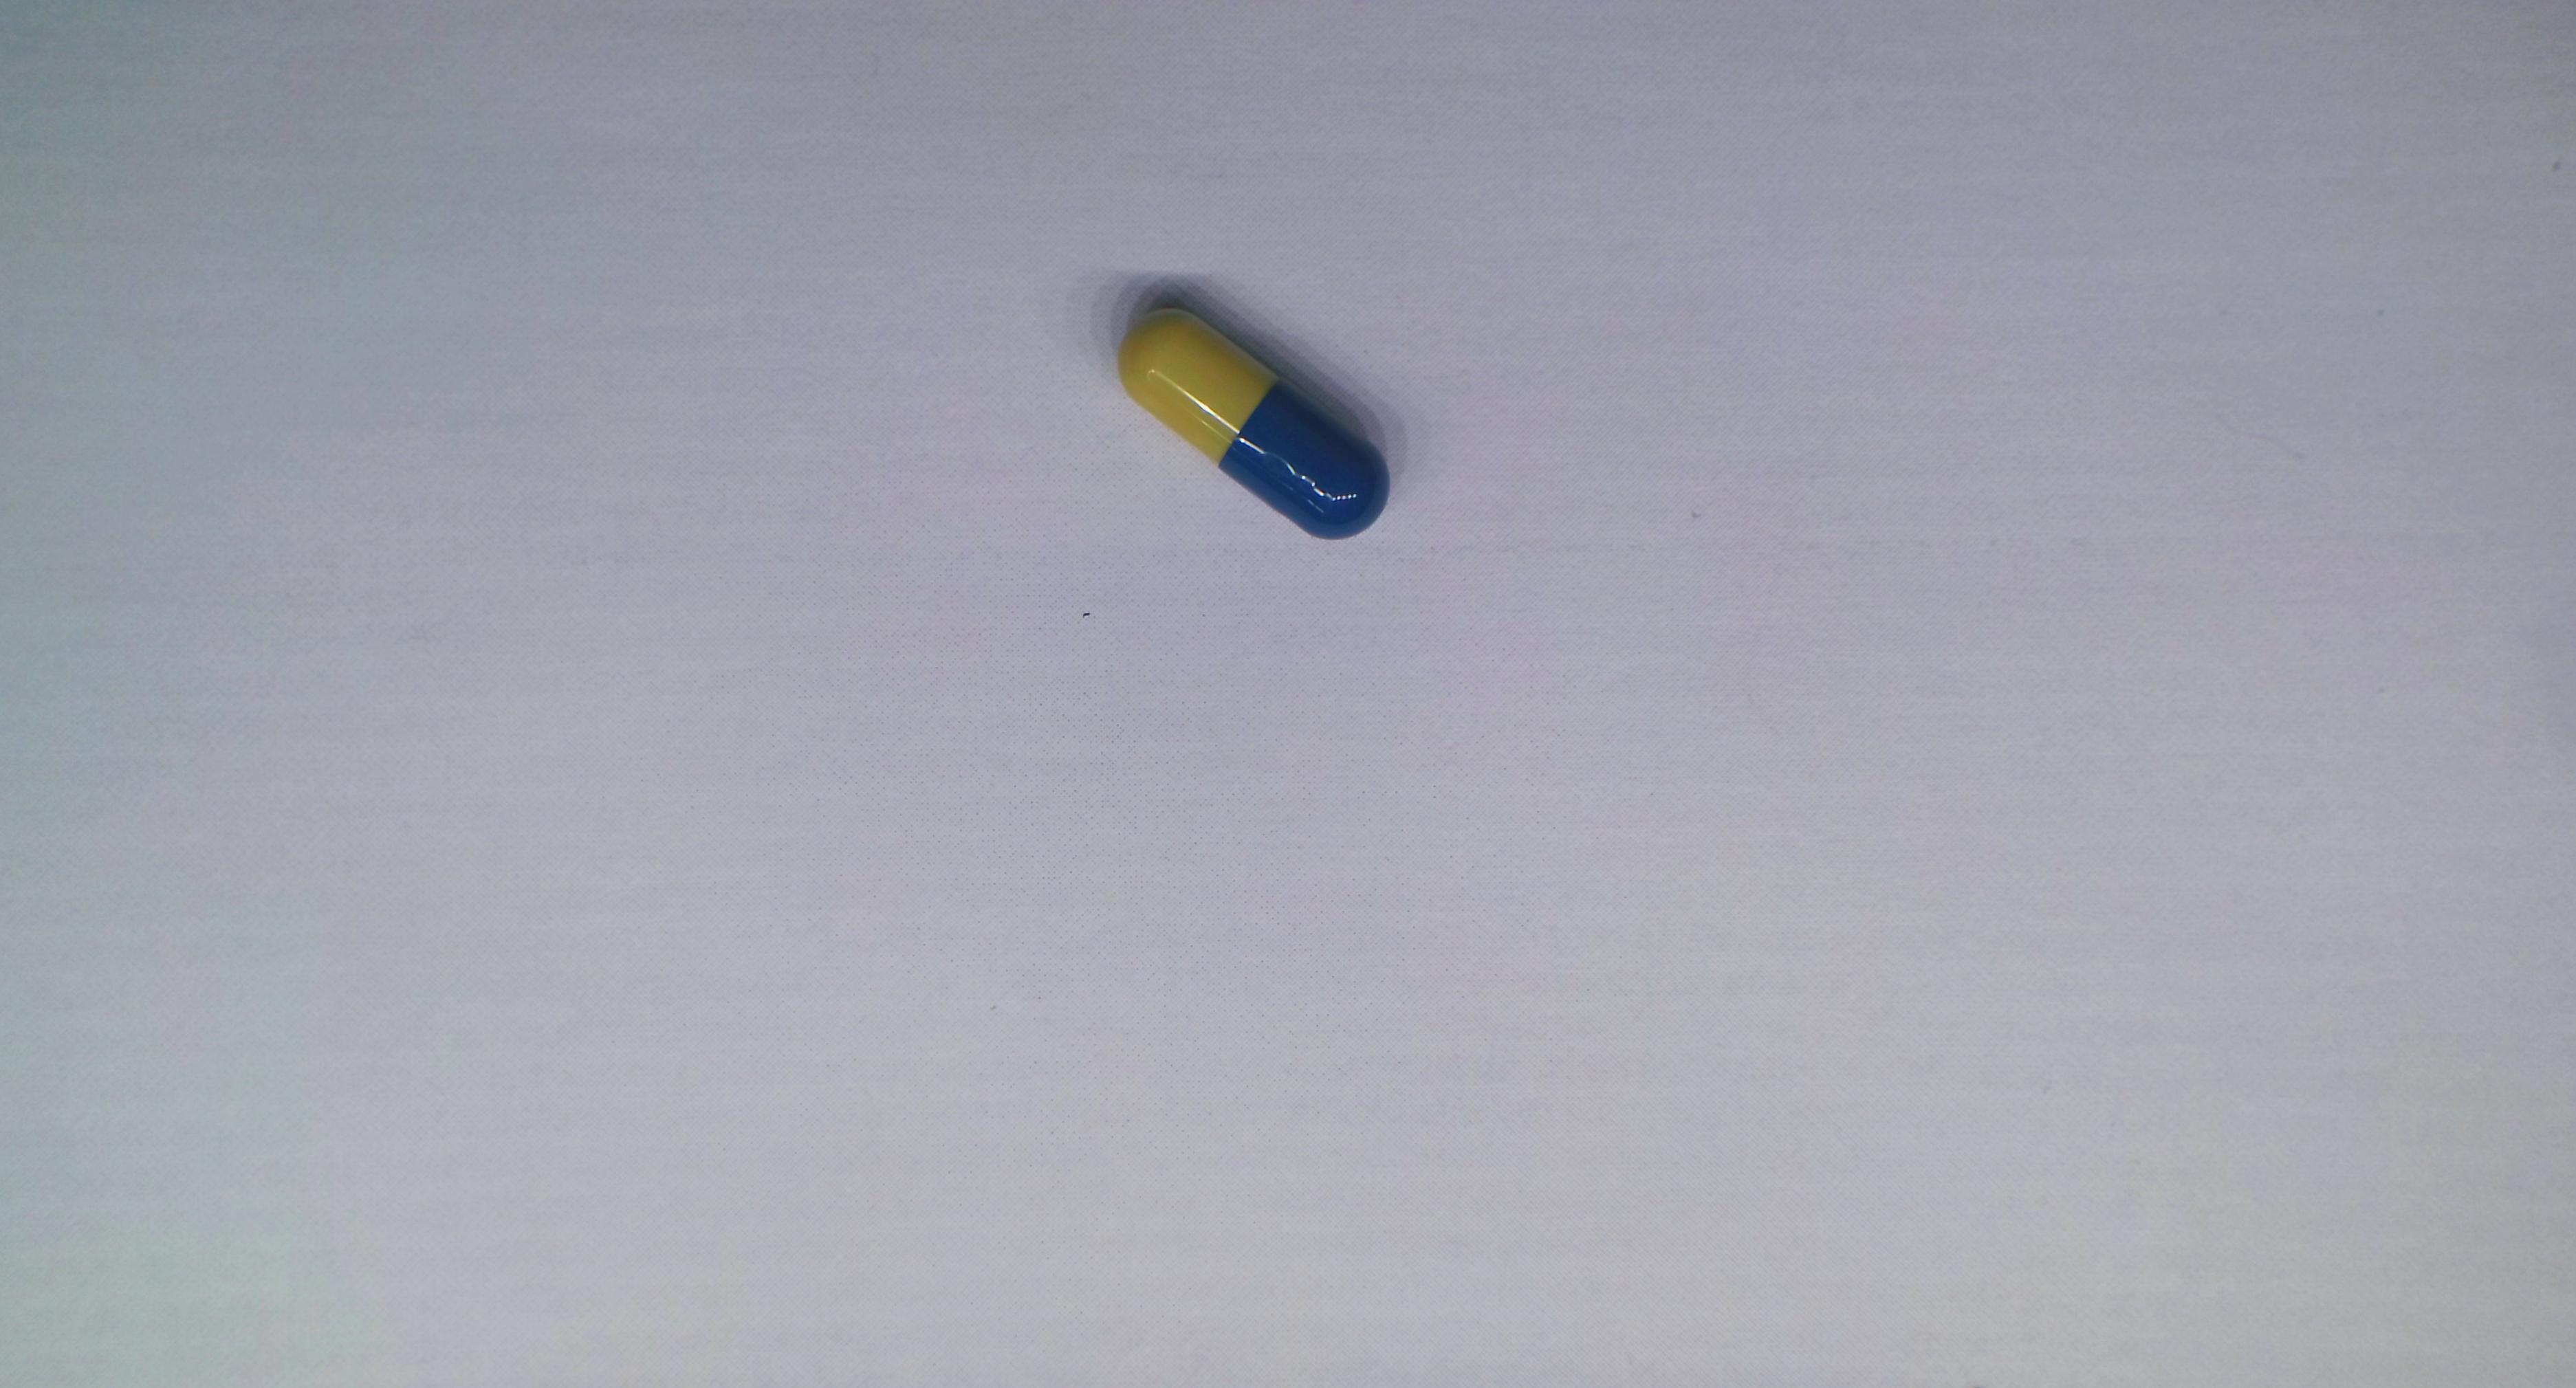

Кажется, понятно, в чем дело. Большая часть таблеток тут - круглая, симметричная по осям или даже радиально (в случае обратной стороны таблеток, где нет насечек). Тут же - капсула, окрашенная в два цвета. Логично, что CV модели, которая не умеет понимать, где важнее обращать внимание на цвет, где на форму, такая пилюля довольно сложна. Стоит ее расположить по-другому - и сами пиксели, а также контуры, поменяются сильно. Для круглых таблеток такое куда менее актуально.

В последнем прогоне, где я решил посмотреть, что будет, если сжать изображения до 100 пикселей, ситуация поменялась, но незначительно, что было ожидаемо. Теперь в топ-5 нет двух пар таблеток с разными сторонами, а общая точность осталась почти идентичной, что подтверждает то, что модели сложно определить изображения, так как у нее мало данных. При этом она отлично предсказывает на обучающей выборке. Классическое переобучение, которое можно решить, если увеличить в хотя бы раза три обучающую выборку. 

В процессе работы мне пришла мысль: можно же было при съемке таблеток двигать белый стол или покрытие, а потом из видео вытащить кадры. Тогда в обучении были бы сотни изображений каждой стороны каждой таблетки, что убрало бы проблему, ну или, как минимум, смягчило бы ее.

### Также расскажу про некоторые наблюдения во время обучения

#### Когда я обучал модель, я несколько раз сталкивался с переобучением. Очень часто валидация застрвала на 2-3%:

```
Эпоха 6/10
                                                                                 
Обучение   - Loss: 4.5049, Accuracy: 9.66%
                                                          
Валидация  - Loss: 5.4517, Accuracy: 1.79%
Нет улучшения: 1/7
Learning Rate: 0.000100
--------------------------------------------------------------------------------

Эпоха 7/10
                                                                                  
Обучение   - Loss: 4.2578, Accuracy: 14.00%
                                                          
Валидация  - Loss: 5.4893, Accuracy: 1.64%
⚠ ПЕРЕОБУЧЕНИЕ! Разрыв train-val: 12.36%
Нет улучшения: 2/7
Learning Rate: 0.000100
--------------------------------------------------------------------------------

Эпоха 8/10
                                                                                  
Обучение   - Loss: 4.0112, Accuracy: 18.53%
                                                          
Валидация  - Loss: 5.5767, Accuracy: 2.08%
⚠ ПЕРЕОБУЧЕНИЕ! Разрыв train-val: 16.44%
✓ Модель сохранена (лучшая точность: 2.08%)
Learning Rate: 0.000100
--------------------------------------------------------------------------------

Эпоха 9/10
                                                                                  
Обучение   - Loss: 3.7761, Accuracy: 23.37%
                                                          
Валидация  - Loss: 5.6295, Accuracy: 3.12%
⚠ ПЕРЕОБУЧЕНИЕ! Разрыв train-val: 20.25%
✓ Модель сохранена (лучшая точность: 3.12%)
Learning Rate: 0.000100
--------------------------------------------------------------------------------

Эпоха 10/10
                                                                                  
Обучение   - Loss: 3.5355, Accuracy: 29.43%
                                                          
Валидация  - Loss: 5.7239, Accuracy: 2.98%
⚠ ПЕРЕОБУЧЕНИЕ! Разрыв train-val: 26.46%
Нет улучшения: 1/7
Learning Rate: 0.000100
```

#### В том числе не помогало и перемешивание:

```
MixUp: True, CutMix: True
Обучаемых параметров: 231,648
```
Это приводило к худшим результатам на трейне, без прогресса в валидации:
```
Эпоха [ 13/20] | Время:  35.14s | LR: 1.50e-04
  Train: Loss=4.0566, Accuracy= 33.23%
  Val:   Loss=5.7990, Accuracy=  2.38%
  ✓ Сохранена лучшая модель: best_model_epoch013_valacc2.38.pth
----------------------------------------------------------------------------------------------------
Эпоха [ 14/20] | Время:  33.80s | LR: 1.16e-04
  Train: Loss=3.9991, Accuracy= 35.76%
  Val:   Loss=5.8456, Accuracy=  2.23%
  ⚠ Нет улучшения уже 1 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 15/20] | Время:  35.21s | LR: 8.46e-05
  Train: Loss=3.9339, Accuracy= 38.11%
  Val:   Loss=5.8330, Accuracy=  2.23%
  ⚠ Нет улучшения уже 2 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 16/20] | Время:  36.19s | LR: 5.62e-05
  Train: Loss=3.9852, Accuracy= 36.77%
  Val:   Loss=5.8315, Accuracy=  2.23%
  ⚠ Нет улучшения уже 3 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 17/20] | Время:  35.21s | LR: 3.25e-05
  Train: Loss=3.8813, Accuracy= 39.37%
  Val:   Loss=5.8755, Accuracy=  2.38%
  ⚠ Нет улучшения уже 4 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 18/20] | Время:  34.25s | LR: 1.47e-05
  Train: Loss=3.9240, Accuracy= 38.25%
  Val:   Loss=5.8616, Accuracy=  2.08%
  ⚠ Нет улучшения уже 5 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 19/20] | Время:  34.78s | LR: 3.69e-06
  Train: Loss=3.7698, Accuracy= 42.70%
  Val:   Loss=5.8278, Accuracy=  2.38%
  ⚠ Нет улучшения уже 6 эпох
----------------------------------------------------------------------------------------------------
Эпоха [ 20/20] | Время:  33.98s | LR: 1.59e-09
  Train: Loss=3.9241, Accuracy= 39.06%
  Val:   Loss=5.8220, Accuracy=  2.38%
  ⚠ Нет улучшения уже 7 эпох
```

#### Лучший вариант у меня получился такой:

```
Используемое устройство: cuda
Начало обучения на устройстве: cuda
Количество параметров модели: 7,596,640
Обучаемых параметров: 642,784
----------------------------------------------------------------------------------------------------
Эпоха [  1/20] | Время:  35.99s | LR: 9.76e-04
  Train: Loss=6.1852, Accuracy=  6.19%
  Val:   Loss=6.4810, Accuracy=  2.83%
----------------------------------------------------------------------------------------------------
Эпоха [  2/20] | Время:  34.94s | LR: 9.05e-04
  Train: Loss=3.5213, Accuracy= 32.21%
  Val:   Loss=7.3905, Accuracy=  2.83%
----------------------------------------------------------------------------------------------------
Эпоха [  3/20] | Время:  35.68s | LR: 7.94e-04
  Train: Loss=2.6043, Accuracy= 52.33%
  Val:   Loss=7.8811, Accuracy=  3.27%
  ✓ Сохранена лучшая модель: best_model_epoch003_valacc3.27.pth
----------------------------------------------------------------------------------------------------
Эпоха [  4/20] | Время:  34.57s | LR: 6.55e-04
  Train: Loss=2.1615, Accuracy= 65.56%
  Val:   Loss=8.1766, Accuracy=  3.42%
  ✓ Сохранена лучшая модель: best_model_epoch004_valacc3.42.pth
----------------------------------------------------------------------------------------------------

>>> Размораживаем backbone (stage 1) <<<
Обучаемых параметров теперь: 3,327,200

Эпоха [  5/20] | Время:  34.20s | LR: 5.01e-04
  Train: Loss=1.8648, Accuracy= 76.05%
  Val:   Loss=8.3801, Accuracy=  2.98%
----------------------------------------------------------------------------------------------------

🎯 Достигнут порог точности на обучающей выборке: 76.05% >= 75.00%
Остановка обучения.

====================================================================================================
ОБУЧЕНИЕ ЗАВЕРШЕНО
====================================================================================================
Всего эпох: 5
Лучшая val accuracy: 3.42%
Лучшая модель: checkpoints/best_model_epoch004_valacc3.42.pth
Финальная train accuracy: 76.05%
Финальная val accuracy: 2.98%
Загружены веса из checkpoints/best_model_epoch004_valacc3.42.pth
  Эпоха чекпоинта: 4
  Val accuracy чекпоинта: 3.42%

Оценка на тестовой выборке...

==================================================
РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
==================================================
Test Accuracy: 25.15%
Правильно классифицировано: 169/672
```

Учитывая, что я много чего менял как в самой модели, так и в обучении, менял заморозку весов, использовал миксер (см. выше), использовал другие приемы, а валидация упорно поднималась максимум до 3.4%, с учетом того, что в пределах одного класса в среднем можно получить только 0, 33, 66 и 100 процентов, напрашивается один вывод - проблема в самих данных, их слишком мало для распознавания довольно похожих по форме таблеток, некоторые из которых еще и явно несимметричны.